In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras import metrics
import pickle
from PIL import Image
from glob import glob

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import parameters
im_files = glob('/contents/images/thumbnail/*.jpg')
imgs = np.array([np.array(Image.open(i)) for i in im_files])
dates = np.array([int(i.split('_')[2]) for i in im_files])

In [3]:
#get a random sample
#make data
training_perc = 0.8
n = int(len(imgs)*training_perc)
np.random.seed(1234)
idx = np.random.permutation(len(imgs))
x_train = imgs[idx[:n]]/255.
x_test = imgs[idx[n:]]/255.
y_train = dates[idx[:n]]
y_test = dates[idx[n:]]

In [4]:
#input parameters
img_rows, img_cols, img_chns = x_train[0].shape
latent_dim = 3
intermediate_dim = 128 
epsilon_std = 1.0
epochs = 60 
filters = 32
num_conv = 3
batch_size = 60 


In [5]:
# tensorflow or theano
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# load saved models
vae = keras.models.load_model('/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
encoder = keras.models.load_model('/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
generator = keras.models.load_model('/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})

# load history if saved
fname = '/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
try:
    with open(fname, 'rb') as fo:
        history = pickle.load(fo)
    print(history)
except:
    print("training history not saved")

/usr/local/lib/python3.5/dist-packages/keras/models.py:274: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.5/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


{'loss': [436510.988804768, 115356.03366623711, 111835.16510953609, 111092.79945231958, 110793.99863079897, 110028.46665592784, 109398.9756765464, 108414.60083762887, 107260.8368234536, 106359.71593105671, 106078.91559278351, 105547.14094716495, 105352.68999677835, 104815.93210373711, 104491.16172680413, 103970.64046391753, 103788.36018041238, 103546.99250966495, 103599.27367912371, 103157.3975515464, 103261.02351804124, 103046.32442010309, 103055.93766108247, 102910.40850515464, 102653.17364690722, 102676.28753221649, 102574.43911082474, 102427.4644007732, 102427.27424291238, 102399.75861791238, 102186.19281572165, 102208.95650773196, 102156.76361146907, 101949.99299291238, 101969.02134342784, 102057.57981636598, 101786.47140786082, 101790.81282216495, 101798.26538337629, 101720.31862113402, 101675.40512242269, 101606.64948453609, 101644.5538015464, 101554.23840206186, 101515.87483891753, 101483.61122744845, 101538.38240979382, 101365.79075386598, 101446.23509987113, 101425.4085051546

In [6]:
# display a 2D manifold of the images
n = 20  # figure with 15x15 images
figure = np.zeros((img_rows * n, img_cols * n, img_chns))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        img = x_decoded[0].reshape(img_rows, img_cols, img_chns)
        figure[i * img_rows: (i + 1) * img_rows,
               j * img_cols: (j + 1) * img_cols] = img
plt.figure(figsize=(40, 40))
plt.imshow(figure, cmap='Greys_r')
plt.show()

ValueError: Error when checking : expected input_3 to have shape (3,) but got array with shape (2,)

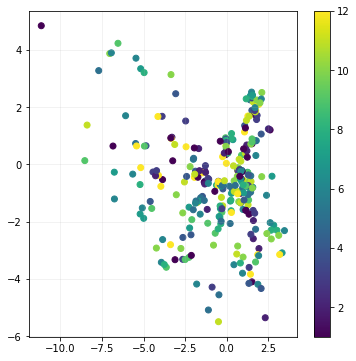

In [9]:
if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.grid(alpha=0.2)
    plt.colorbar()
    plt.show()

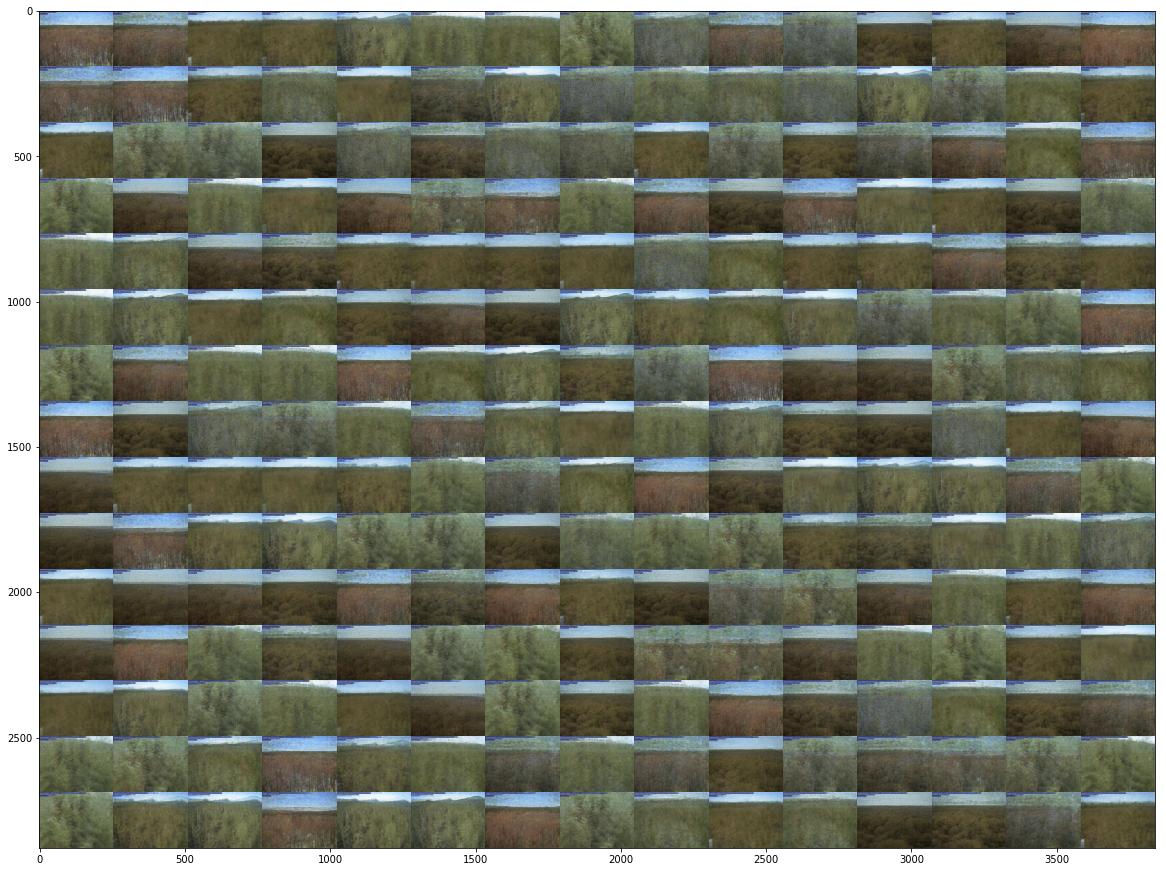

In [8]:
# display images generated from randomly sampled latent vector
n = 15
img_size = 32
figure = np.zeros((img_rows * n, img_cols * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_rows, img_cols, img_chns)
        figure[i * img_rows: (i + 1) * img_rows,j * img_cols: (j + 1) * img_cols] = img

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()